In [10]:
#%pip install prophet

StatementMeta(biweprd2sparkpl, 168, 12, Finished, Available)

**Recupero dati tramite Spark**

In [11]:
%%spark 
import org.apache.spark.sql.SqlAnalyticsConnector._ 
import com.microsoft.spark.sqlanalytics.utils.Constants 

//val sql_pool_name = "bi-we-prd1-synws.sql.azuresynapse.net"
val sql_pool_name = mssparkutils.env.getWorkspaceName()+".sql.azuresynapse.net"
val db_name = "bi_we_prd1_synws_sqlpool"
val schema_name = "ml"
val table_name = "vw_fact_modello_forecast_spedizioni_training_set_numero_spedizioni_daily_all_clienti" 

val df = spark.read.sqlanalytics(s"$db_name.$schema_name.$table_name")
df.createOrReplaceTempView( "training_table_numero_spedizioni_daily_all_clienti" )

StatementMeta(biweprd2sparkpl, 168, 13, Finished, Available)

import org.apache.spark.sql.SqlAnalyticsConnector._
import com.microsoft.spark.sqlanalytics.utils.Constants
sql_pool_name: String = bi-we-prd1-synws.sql.azuresynapse.net
db_name: String = bi_we_prd1_synws_sqlpool
schema_name: String = ml
table_name: String = vw_fact_modello_forecast_spedizioni_training_set_numero_spedizioni_daily_all_clienti
df: org.apache.spark.sql.DataFrame = [ds: timestamp, unique_id: int ... 11 more fields]


**Creazione funzione di partizionamento**

In [12]:
# Comando SQL per selezionare il training set
sql = 'select * from training_table_numero_spedizioni_daily_all_clienti order by unique_id, ds'

# Parizionamento dei dati per la chiave univoca per creare esecuzioni parallele del modello
unique_id_pd = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['unique_id'])).cache()

unique_id_pd = unique_id_pd.toPandas()


StatementMeta(biweprd2sparkpl, 168, 14, Finished, Available)

**Esecuzione del modello (parametri scelti da cross validazione)**

StatementMeta(biweprd2sparkpl, 168, 15, Finished, Available)

08:30:31 - cmdstanpy - INFO - Chain [1] start processing
08:30:31 - cmdstanpy - INFO - Chain [1] done processing


Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
input tempfile: /tmp/tmprlz0k2x3/1xc5nh_9.json
input tempfile: /tmp/tmprlz0k2x3/_3yq65xn.json
idx 0
running CmdStan, num_threads: None
CmdStan args: ['/home/trusted-service-user/cluster-env/env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69804', 'data', 'file=/tmp/tmprlz0k2x3/1xc5nh_9.json', 'init=/tmp/tmprlz0k2x3/_3yq65xn.json', 'output', 'file=/tmp/tmprlz0k2x3/prophet_modelb9mwgqr3/prophet_model-20231219083031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
Chain [1] start processing
Chain [1] done processing



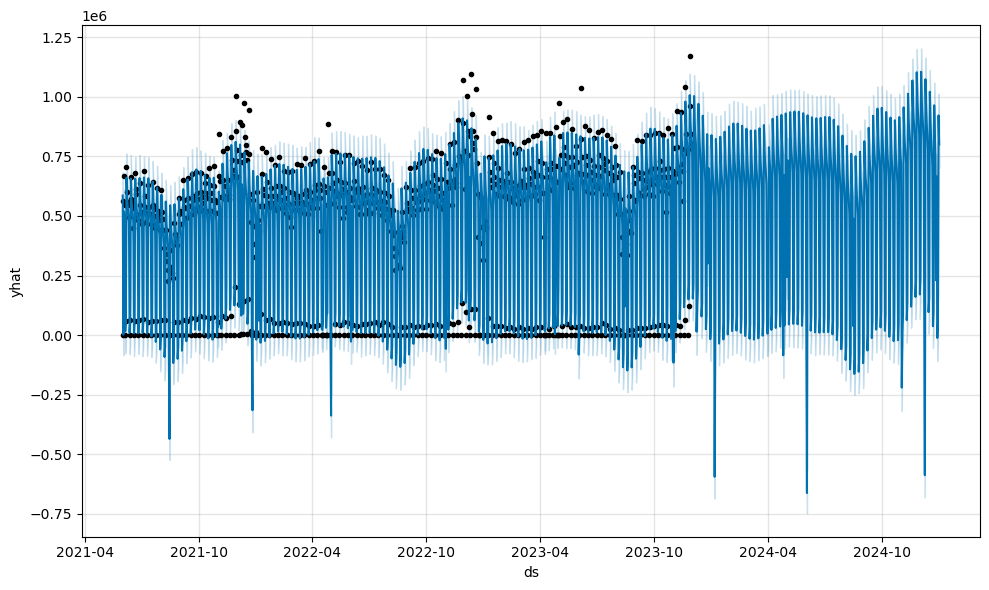

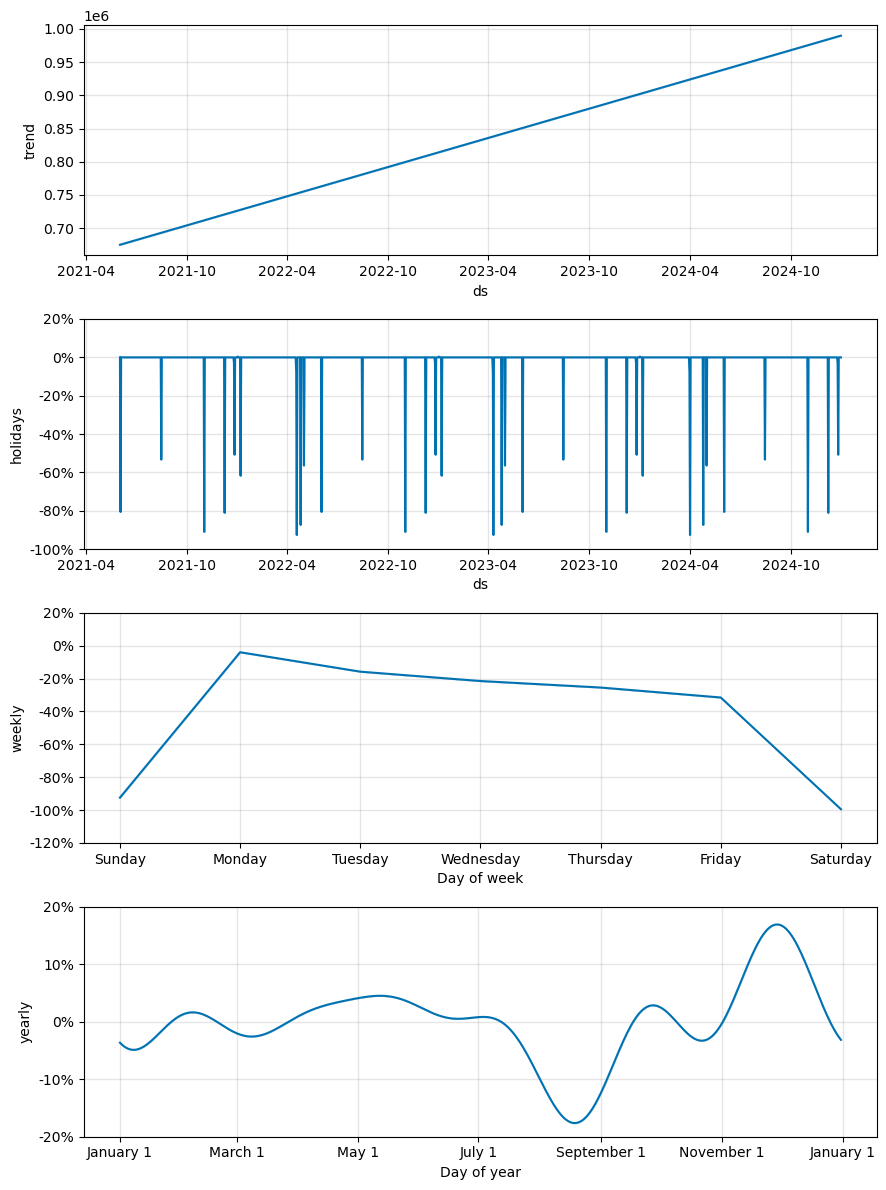

In [13]:
from pyspark.sql.types import *
from prophet import Prophet
from prophet.make_holidays import make_holidays_df


yearly_seasonality = unique_id_pd['yearly_seasonality'].iloc[0]
yearly_seasonality_fourier_order = unique_id_pd['yearly_seasonality_fourier_order'].iloc[0]
changepoint_prior_scale = unique_id_pd['changepoint_prior_scale'].iloc[0]
seasonality_prior_scale = unique_id_pd['seasonality_prior_scale'].iloc[0]
seasonality_mode = unique_id_pd['seasonality_mode'].iloc[0]
forecast_horizon = unique_id_pd['forecast_horizon'].iloc[0]
weekly_seasonality_fourier_order = unique_id_pd['weekly_seasonality_fourier_order'].iloc[0]

model = Prophet(
        #interval_width=0.85
     # , 
        yearly_seasonality= yearly_seasonality_fourier_order
      , weekly_seasonality=weekly_seasonality_fourier_order
      , changepoint_prior_scale = changepoint_prior_scale
      , seasonality_prior_scale = seasonality_prior_scale
      ,  seasonality_mode = seasonality_mode)

model.add_country_holidays(country_name='IT')

#model.add_seasonality(name='year', period=12, fourier_order = 10)
model.fit( unique_id_pd )

future_pd = model.make_future_dataframe(
periods=forecast_horizon, 
freq='D',
include_history=True
)

forecast_pd = model.predict( future_pd )  

f_pd = forecast_pd.set_index('ds')


fig = model.plot(forecast_pd, xlabel='ds',
ylabel=r'yhat')

fig2 = model.plot_components(forecast_pd)
fig2.show()

print()

**Creazione vista temporanea sui risultati**

**Memorizzazione dati**

In [14]:
# Comando SQL per selezionare il training set
sql = 'select * from training_table_numero_spedizioni_daily_all_clienti order by unique_id, ds'

# Parizionamento dei dati per la chiave univoca per creare esecuzioni parallele del modello
unique_id_part = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['unique_id'])).cache()

StatementMeta(biweprd2sparkpl, 168, 16, Finished, Available)

In [15]:

from pyspark.sql.types import *
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('unique_id',IntegerType()),
  #StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])
  
  
# Creazione udf in modo che viene eseguita in parallelo per ogni serie

from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( unique_id_pd ):

  it_holidays = make_holidays_df(
    year_list=[2021 + i for i in range(5)], country='IT'
  )

  yearly_seasonality = unique_id_pd['yearly_seasonality'].iloc[0]
  yearly_seasonality_fourier_order = unique_id_pd['yearly_seasonality_fourier_order'].iloc[0]
  changepoint_prior_scale = unique_id_pd['changepoint_prior_scale'].iloc[0]
  seasonality_prior_scale = unique_id_pd['seasonality_prior_scale'].iloc[0]
  seasonality_mode = unique_id_pd['seasonality_mode'].iloc[0]
  forecast_horizon = unique_id_pd['forecast_horizon'].iloc[0]
  weekly_seasonality_fourier_order = unique_id_pd['weekly_seasonality_fourier_order'].iloc[0]

  model = Prophet(
        interval_width=0.85
      , yearly_seasonality= yearly_seasonality_fourier_order
      , weekly_seasonality=weekly_seasonality_fourier_order
      , changepoint_prior_scale = changepoint_prior_scale
      , seasonality_prior_scale = seasonality_prior_scale
      ,  seasonality_mode = seasonality_mode)
  
  #if yearly_seasonality:
    #model.add_seasonality(name='yearly', period=7 * 52, fourier_order = 10)
    
  model.add_country_holidays(country_name='IT')


  model.fit( unique_id_pd )

  future_pd = model.make_future_dataframe(
    periods=forecast_horizon, 
    freq='D',
    include_history=False
    )
  
  forecast_pd = model.predict( future_pd )  
  
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  #st_pd = unique_id_pd[['ds','unique_id']].set_index('ds')
  
  #results_pd = f_pd.join( st_pd, how='left' )
  results_pd = f_pd
  results_pd.reset_index(level=0, inplace=True)
  
  results_pd['unique_id'] = unique_id_pd['unique_id'].iloc[0]

  return results_pd[ ['ds', 'unique_id', 'yhat', 'yhat_upper', 'yhat_lower'] ]
  
  
# forecasting
results = (
unique_id_part
.groupBy('unique_id')
.apply(forecast_sales))



StatementMeta(biweprd2sparkpl, 168, 17, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.


In [16]:

results.cache()

results.createOrReplaceTempView("modello_forecast_spedizioni_numero_spedizioni_daily_all_clienti")


StatementMeta(biweprd2sparkpl, 168, 18, Finished, Available)

**Popolamento tabella di output**

In [17]:

%%spark 
import org.apache.spark.sql.SqlAnalyticsConnector._ 
import com.microsoft.spark.sqlanalytics.utils.Constants 

//val sql_pool_name = "bi-we-prd1-synws.sql.azuresynapse.net"
val sql_pool_name = mssparkutils.env.getWorkspaceName()+".sql.azuresynapse.net"
val db_name = "bi_we_prd1_synws_sqlpool"
val schema_name = "ml"
val table_name = "fact_modello_forecast_spedizioni_numero_spedizioni_daily_all_clienti_stg" 

// Scrittura nel SQL pool 
spark.sqlContext.sql("SELECT ds, cast(unique_id as int) as unique_id, cast(yhat as float) as y, cast(yhat_upper as float) as y_upper, cast(yhat_lower as float) as y_lower FROM modello_forecast_spedizioni_numero_spedizioni_daily_all_clienti").write.mode("overwrite").option(Constants.SERVER,s"$sql_pool_name").synapsesql(s"$db_name.$schema_name.$table_name" , Constants.INTERNAL)


StatementMeta(biweprd2sparkpl, 168, 19, Finished, Available)

import org.apache.spark.sql.SqlAnalyticsConnector._
import com.microsoft.spark.sqlanalytics.utils.Constants
sql_pool_name: String = bi-we-prd1-synws.sql.azuresynapse.net
db_name: String = bi_we_prd1_synws_sqlpool
schema_name: String = ml
table_name: String = fact_modello_forecast_spedizioni_numero_spedizioni_daily_all_clienti_stg
